# Lesson 09 - Overfitting

> What is overfitting and how can it be avoided?

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/dslectures/master?filepath=notebooks%2Flesson09-overfitting.ipynb)

Already John von Neumann, one of the founding fathers of computing, new that fitting complex models to data is a tricky business:
>With four parameters I can fit an elephant, and with five I can make him wiggle his trunk.
>
> \- John von Neumann

<p align="left">
<img src='./images/elephant.jpg' width='400'>
<p style="text-align: left;"> <b>Figure:</b> Irrelevant image. </p>


## Goals
Overfitting is a phenomena that can always occur when a model is fitted to data. Therefore, it is important to understand what it entails and how it can be avoided. In this notebook we will address theese three questions related to overfitting:
1. What is overfitting?
2. How can we measure overfitting?
3. How can overfitting be avoided?

## Data
To study overfitting we take polynomials as our toy model for fitting a function to data. Later we will see that the presented approaches are not specific to polynomials and can be extended to other *supervised* machine learning methods such as linear regressors, tree classifiers or support vector machines.

### Import dependencies

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold


np.warnings.filterwarnings('ignore')


### Generate data
A polynomail of degree $n$ has the form:
$$f(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots+w_n\cdot x^n$$
In this block we generate a random polynomial of degree 4 and sample noisy data from it.

The function `numpy.polyval(w, x)` evaluates a polynomial with weights `w` at the positions `x` and returns the values for `y`.

In [ ]:
n_samples = 100
poly_degree = 4
rand_seed = 42

# this step makes sure, that we get the same
# random data every time we run the code.
np.random.seed(rand_seed)

# generate the weights w of the polynomial with
w = np.random.rand(poly_degree+1)

# generate random points on the x axis
x = (0.5-np.random.rand(n_samples))*2

# evalute polynomial with weight w at positions x
y_true = np.polyval(w, x)

# add noise samples from the normal gaussian
# distribution to the data.
y_data = y_true + np.random.randn(n_samples)/5

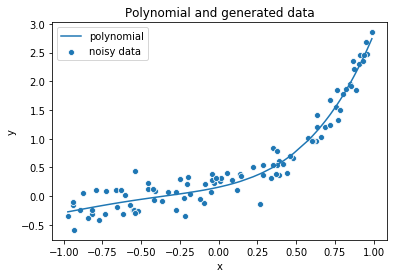

In [ ]:
plt.title('Polynomial and generated data')
sns.scatterplot(x,y_data, label='noisy data')
sns.lineplot(x, y_true, label='polynomial')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Fitting a function
Numpy comes with the function `numpy.polyfit(x, y, d)` that can be used to fit a polynomail of degree `d` to datapoints `(x, y)`. In machine learning predictions and estimations of values are often denoted with a hat ($\hat{y}$ for predictions of $y_{true}$), hence the ending `_hat` in code.

In [ ]:
w_hat = np.polyfit(x, y_data, 4)

With the estimations of the weights `w_hat` we can calulate the fitted values at position `x`.

In [ ]:
y_hat = np.polyval(w_hat, x)

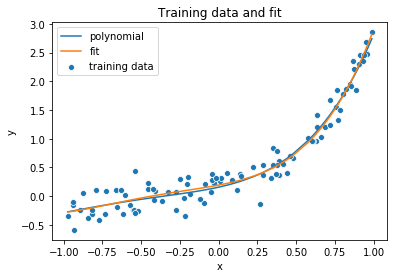

In [ ]:
plt.title('Training data and fit')
sns.scatterplot(x, y_data, label='training data')
sns.lineplot(x, y_true, label='polynomial')
sns.lineplot(x, y_hat, label='fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Overfitting the data
We can also overfit the data by fitting a higher degree polynomial to the training data.

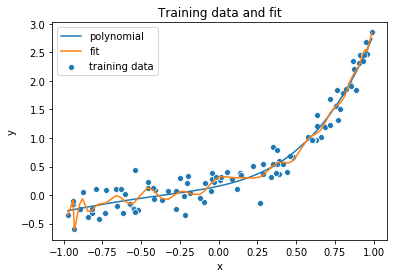

In [ ]:
w_hat = np.polyfit(x, y_data, 30)
y_hat = np.polyval(w_hat, x)

plt.title('Training data and fit')
sns.scatterplot(x, y_data, label='training data')
sns.lineplot(x, y_true, label='polynomial')
sns.lineplot(x, y_hat, label='fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We observe that our data fit exhibits strange wiggles. The reason for this is that the polynomial has enough degrees of freedom to start fitting the noise in the data. This is bad since new sampled from our function likely don't fall on this curve. This means that this model does **not generalize** to new data.

### Error
We can quantify this by looking at the estimation error. To to this we calulate the root mean squar error between the estimation and the data points.

In [ ]:
def RMSE(y, y_true):
    """
    Calulate root mean square error.
    
    Args:
        y: estimations (1-D numpy.array) 
        y_true: labels (1-D numpy.array)
        
    returns:
        RMSE (float)
    """
    
    return np.sqrt(np.mean((y-y_true)**2))

Error between data points and underlying function:

In [ ]:
RMSE(y_data, y_true)

0.18402037604152494

Erro between data points and function (polynomial of degree 30):

In [ ]:
RMSE(y_data, y_hat)

0.1658258399446861

We observe that the error of our fitted curve is smaller than the actual curve that produced the data. Since we only added random noise, this is a strong indication that we are overfitting the data. In reality we do not have access to `y_true`, the underlying function that produced our dataset, hence we must rely on other techiques such as Train/Test splits and cross-validation to monitor overfitting.

## Train/Test Splits

One tool to investigate if a model is overfitting are train test splits. The idea of this approach is to train a model one part of the data and then evaluate its performance a holdout set to see how well it generalizes.

Fortunately, the `scikit-learn` library comes with a `train_test_split` function that simplifies splitting the data into train and test set. It takes any number of input objects and returns twice as many objects splitted according to the split ratio specified in `test_size`.

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y_data, test_size=.1)

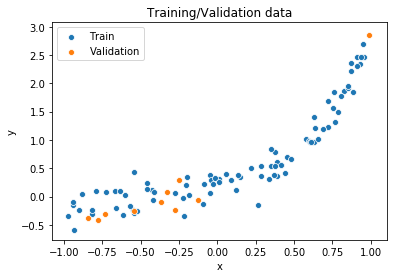

In [ ]:
plt.title('Training/Validation data')
sns.scatterplot(x_train, y_train, label='Train')
sns.scatterplot(x_valid, y_valid, label='Validation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

First we fit a polynomial to the training data:

In [ ]:
w_hat = np.polyfit(x_train, y_train, 4)

Then we evaluate the polynomial for both the train and the validation set:

In [ ]:
y_hat_train = np.polyval(w_hat, x_train)
y_hat_valid = np.polyval(w_hat, x_valid)

We can then evaluate the error of the predictions of both the training and the validation data:

In [ ]:
print('training error :   %.3f ' % (RMSE(y_train, y_hat_train)))
print('validation error : %.3f ' % (RMSE(y_valid, y_hat_valid)))

training error :   0.180 
validation error : 0.209 


We can see that the trainin error is slightly smaller than the validation error. This is normal we model has not seen the validation data at all and was trained on the training set. 

However, as we fit a more and more complex model to the data there is a tipping point where the validation error starts to get bigger while the training error still gets smaller. This is where we start to overfit. 

We want to investigate this on the polynomial:

In [ ]:
a_list = []

In [ ]:
a_list.append(3)

In [ ]:
a_list

[1, 2, 3]

In [ ]:
# create empty lists for training and validation error
valid_error = []
train_error = []

# create a list with the polynomial degrees we want to test
poly_degrees = np.linspace(1,15,15)

for d in poly_degrees:
    # for each degree fit the polynomial
    w_hat = np.polyfit(x_train, y_train, d)
    
    # calculate training and validation estimates
    y_hat_train = np.polyval(w_hat, x_train)
    y_hat_valid = np.polyval(w_hat, x_valid)
    
    # append the training and validation error to lists
    train_error.append(RMSE(y_train, y_hat_train))
    valid_error.append(RMSE(y_valid, y_hat_valid))

In [ ]:
def plot_train_valid_accuracy(params, train_acc, valid_acc, param_label):
    """
    Plot fitting curve over a set of parameters for training and validation set.
    
    args:
        params: list of parameters
        train_acc: list of training accuracies
        valid_acc: list of validation accuracies
    """
    
    plt.title('Fitting Graph')
    sns.lineplot(params, train_acc, label='Training')
    sns.lineplot(params, valid_acc, label='Validation')
    plt.grid(True)
    plt.ylabel('RMSE')
    plt.xlabel(param_label)
    plt.show()

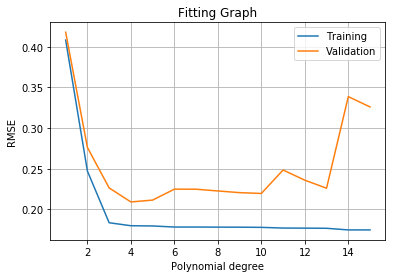

In [ ]:
plot_train_valid_accuracy(poly_degrees, train_error, valid_error, 'Polynomial degree')

We can see that the validation error is smallest at degree=4 while the training error decreases monotonically with additional degrees. This is what we would expect for data we created with a polynomial of degree=4.

Although this apporach worked well in our example, it could well be that our results are caused by a especially bad or good train/test split and are not representative of the data in general. Cross-validation is a method to do this more systematically.

## Cross-validation
In cross-validation the data is split into n equally sized pieces called **folds**. For each fold the data is trained on all folds except one which is held out and used for validation. This is done n-times and the error and metrics are calculated as the mean for each **fold**.

The `scikit-learn` library provides again a function without much pain. Assume we have an array for 6 samples and want to cross-validate with 3 folds. This can be done in the following fashion:

In [ ]:
# create dummy data with 6 entries
dummy_data = np.array([1,2,3,4,5,6])

# create 3-fold cross-validation
kf = KFold(3)

# feeding the data to kf.split creates a list (technically a generator)
# of train and valid indices we can iterate through:
for train_index, valid_index in kf.split(dummy_data):
    
    # we can slice out the training and validation data with the indices
    print('train:', dummy_data[train_index], ', valid:', dummy_data[valid_index])

train: [3 4 5 6] , valid: [1 2]
train: [1 2 5 6] , valid: [3 4]
train: [1 2 3 4] , valid: [5 6]


Now we apply this to the polynomial data. In this case we want to do a 10-fold cross-validation.

In [ ]:
kf = KFold(10)

In [ ]:
valid_error = []
train_error = []
poly_degrees = np.linspace(1,15,15)

for d in poly_degrees:
    # for each degree we save the train/valid
    # error for each each fold.
    tmp_valid_error = []
    tmp_train_error = []
    
    for train_index, valid_index in kf.split(x):
        # for each fold we split the data into
        # training and validation sets
        x_train, y_train = x[train_index], y_data[train_index]
        x_valid, y_valid = x[valid_index], y_data[valid_index]
    
        # this step is identical to the train/test
        # split example where we fit the training data
        w_hat = np.polyfit(x_train, y_train, d)
        y_hat_train = np.polyval(w_hat, x_train)
        y_hat_valid = np.polyval(w_hat, x_valid)

        tmp_train_error.append(RMSE(y_train, y_hat_train))
        tmp_valid_error.append(RMSE(y_valid, y_hat_valid))
    
    # after we completed all cross-validation folds
    # we calculate the train/valid errors for each
    # degree as the mean over all folds.
    train_error.append(np.mean(tmp_train_error))
    valid_error.append(np.mean(tmp_valid_error))

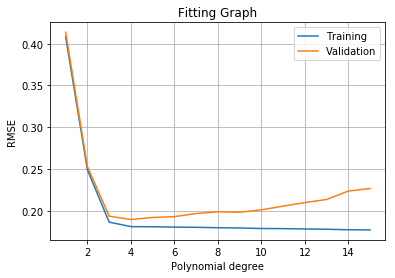

In [ ]:
plot_train_valid_accuracy(poly_degrees, train_error, valid_error, 'Polynomial degree')

We see that the fitting graph is indeed very similar to the one before, although a bit smoother. This is because both the training and the validation curve are the result of the average of 10 individually trained models.

### Overfit
Lets define the overfit error as: $E_{overfit}=E_{valid}-E_{train}$ where $E$ is the error. Let's plot the overfit as a function of polynomial degree:

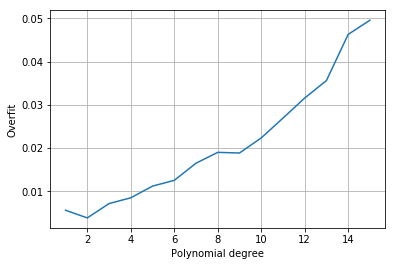

In [ ]:
overfit_error = np.array(valid_error)-np.array(train_error)
sns.lineplot(poly_degrees, overfit_error)
plt.grid(True)
plt.ylabel('Overfit')
plt.xlabel('Polynomial degree')
plt.show()

We observe that the overfit error almost monotonically increases with the degrees of the polynomial.

**Note**: We are not looking to minimize the overfit error but we are looking for the minimum validation error. It is normal to be slightly overfitting, but we don't want to overfit for the cost gaining validation error!

# Excercise

1. Plot the fitting graph for different sample sizes (n=[10, 100, 1000, 10000]) for the same range of polynomial degrees.
2. Plot the the overfit Error for all sample sizes in one plot.
3. How do you explain the differences in the curves?